# Exploratory Data Analysis


## 1. Setup


### 1.1 Imports


In [1]:
from scripts.models.target_independent import test_independant_models
from scripts.preprocessing.data_loader import load_preprocessed_dataset, split_features_targets
from scripts.visual.plot_results import plot_average_learning_curves, plot_metric_comparison
from scripts.visual.plot_distributions import (
    save_plots,
    plot_group_histogram,
    plot_group_boxplot,
    plot_group_line_chart,
    plot_group_spatial_heatmap,
    plot_spatial_heatmap,
)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 1.2 Loading Dataset


In [2]:
# Load data into DataFrames.
df = load_preprocessed_dataset()
features, targets = split_features_targets(df)
print(f"📊 Data: \n {df.head()}\n")
variables = [
    "air_temperature",
    "ocean_temperature",
    "bedrock_elevation",
    "precipitation",
    "ice_thickness",
    "ice_mask",
    "ice_velocity",
]
boundary_conditions = [
    "precipitation",
    "air_temperature",
    "ocean_temperature",
    "bedrock_elevation",
]

📊 Data: 
      x   y  bedrock_elevation  ice_thickness  ice_velocity  ice_mask  \
14 -11  25       -4793.874023            0.0           0.0         4   
15 -10  25       -4420.734863            0.0           0.0         4   
16  -9  25       -5434.435547            0.0           0.0         4   
17  -8  25       -4653.052246            0.0           0.0         4   
18  -7  25       -5059.603027            0.0           0.0         4   

    precipitation  air_temperature  ocean_temperature  year  
14     427.970673       265.616150         272.858917  2015  
15     415.765472       265.439117         272.790131  2015  
16     409.452698       265.334229         272.737061  2015  
17     421.175476       265.293182         272.697327  2015  
18     451.815063       265.296570         272.666046  2015  



## 2. Feature Space


In [3]:
for feature in variables:
    save_plots(df, f"out/images/{feature}", feature)

### 2.0 Data Descriptions


In [4]:
# Describe the data.
print(f"📊 Data description: \n {df.describe()}\n")

📊 Data description: 
                  x            y  bedrock_elevation  ice_thickness  \
count  194102.0000  194102.0000      194102.000000  194102.000000   
mean        0.0000       0.0000       -2013.383562     776.512295   
std        13.4209      13.4209        2094.333331    1166.002566   
min       -25.0000     -25.0000       -5795.390137       0.000000   
25%       -11.0000     -11.0000       -4091.489746       0.000000   
50%         0.0000       0.0000       -1448.714233       0.000000   
75%        11.0000      11.0000        -204.746490    1631.427490   
max        25.0000      25.0000        2638.405518    4591.036621   

        ice_velocity       ice_mask  precipitation  air_temperature  \
count  194102.000000  194102.000000  194102.000000    194102.000000   
mean       40.480300       3.225830     538.905172       257.661508   
std       277.731583       0.957322     364.568643        17.149065   
min         0.000000       2.000000       0.127106       214.405243   
2

### 2.1 NaN Values


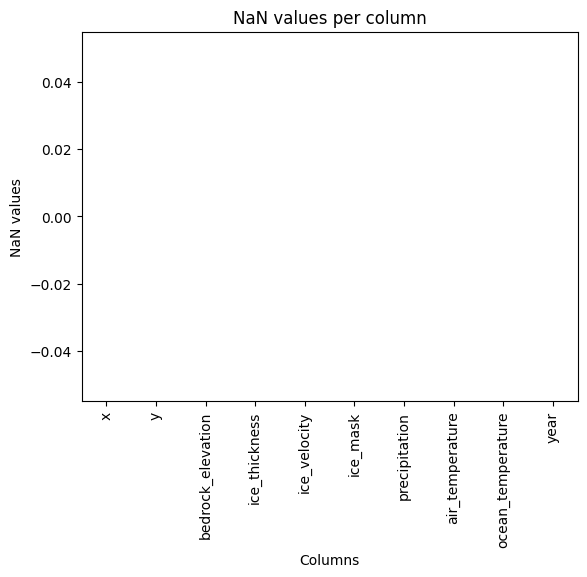

📊 NaN values per column: 
 x                    0
y                    0
bedrock_elevation    0
ice_thickness        0
ice_velocity         0
ice_mask             0
precipitation        0
air_temperature      0
ocean_temperature    0
year                 0
dtype: int64

📊 NaN values proportion per column: 
 x                    0.0
y                    0.0
bedrock_elevation    0.0
ice_thickness        0.0
ice_velocity         0.0
ice_mask             0.0
precipitation        0.0
air_temperature      0.0
ocean_temperature    0.0
year                 0.0
dtype: float64



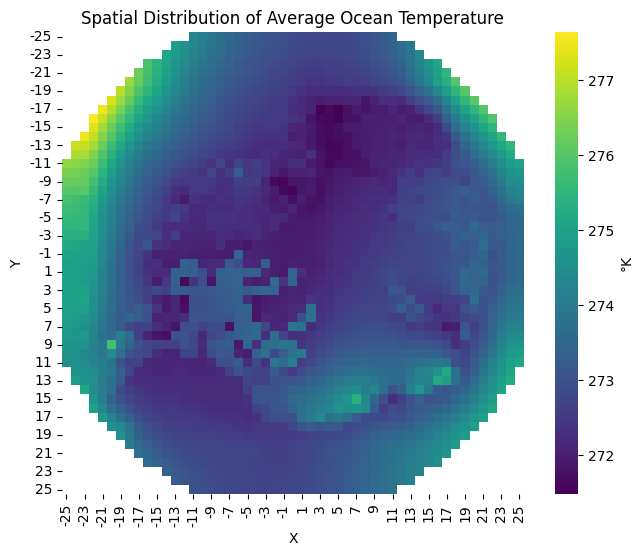

In [5]:
# Plot NaN values in each column
NaN_values = df.isna().sum()
sns.barplot(x=NaN_values.index, y=NaN_values.values)
plt.xticks(rotation=90)
plt.title("NaN values per column")
plt.xlabel("Columns")
plt.ylabel("NaN values")
plt.show()

print(f"📊 NaN values per column: \n {df.isna().sum()}\n")

# calculate each columns proportion of NaN values
NaN_proportion = df.isna().sum() / len(df)
print(f"📊 NaN values proportion per column: \n {NaN_proportion}\n")

# Plot a heatmap of NaN values
plot_spatial_heatmap(df, "ocean_temperature")

### 2.2 Outliers


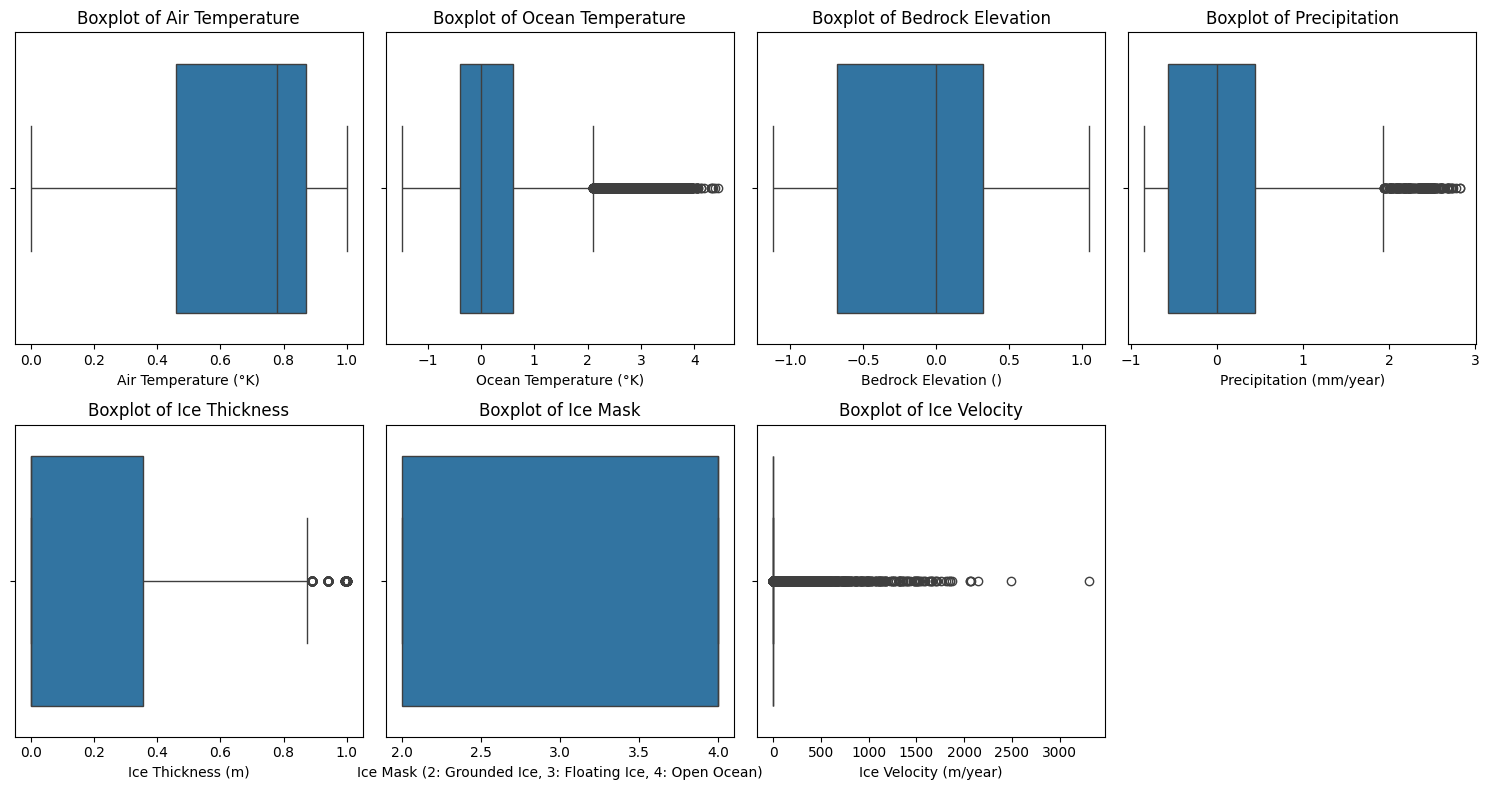

In [6]:
plot_group_boxplot(df, variables, 2, 4)

### 2.3 Duplicates


In [5]:
print(f"📊 Duplicates: {df.duplicated().sum()}")

📊 Duplicates: 0


### 2.4 Univariate Analysis


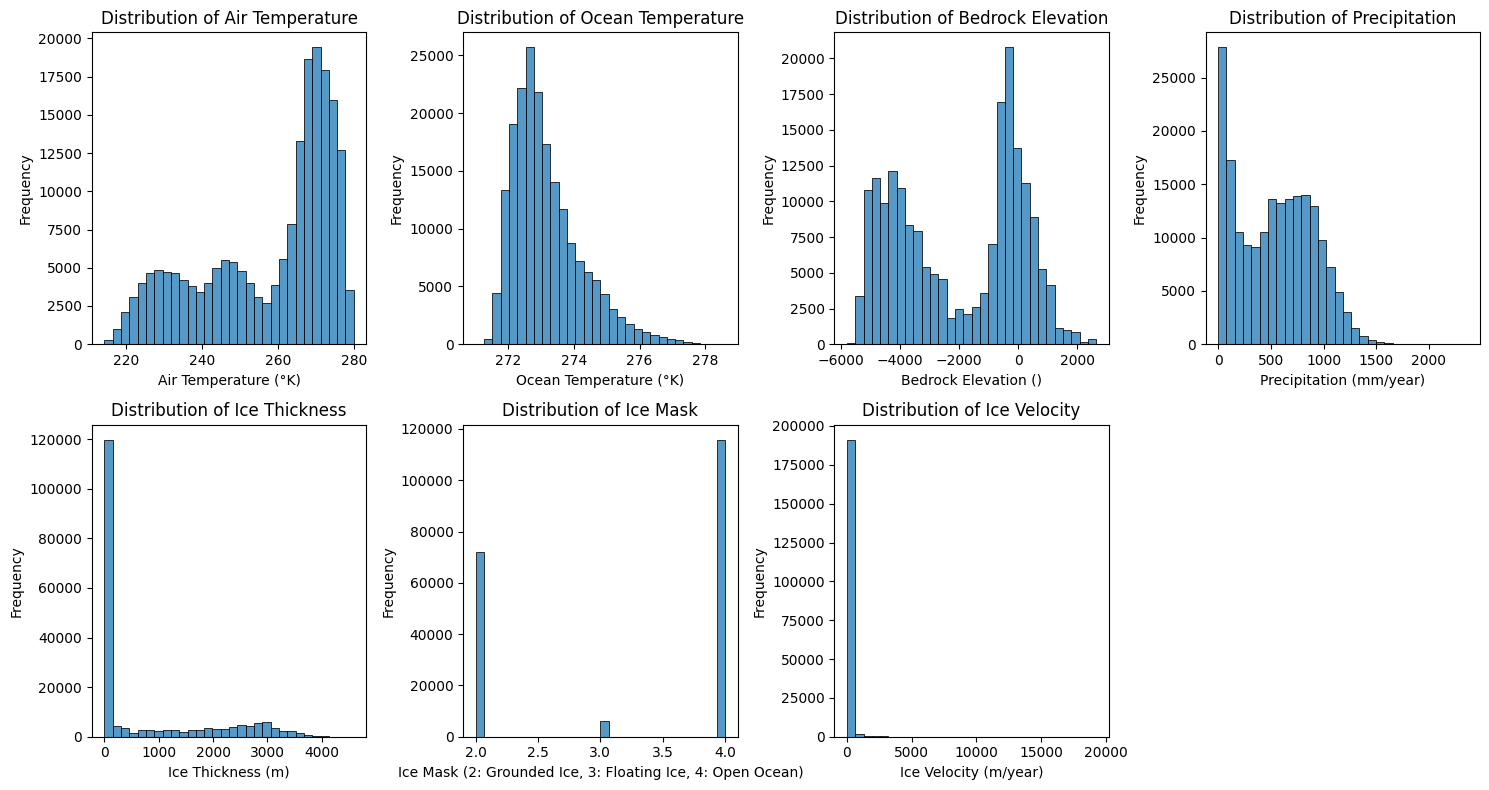

In [6]:
plot_group_histogram(df, variables, 2, 4)

### 2.5 Static Spatial Representations


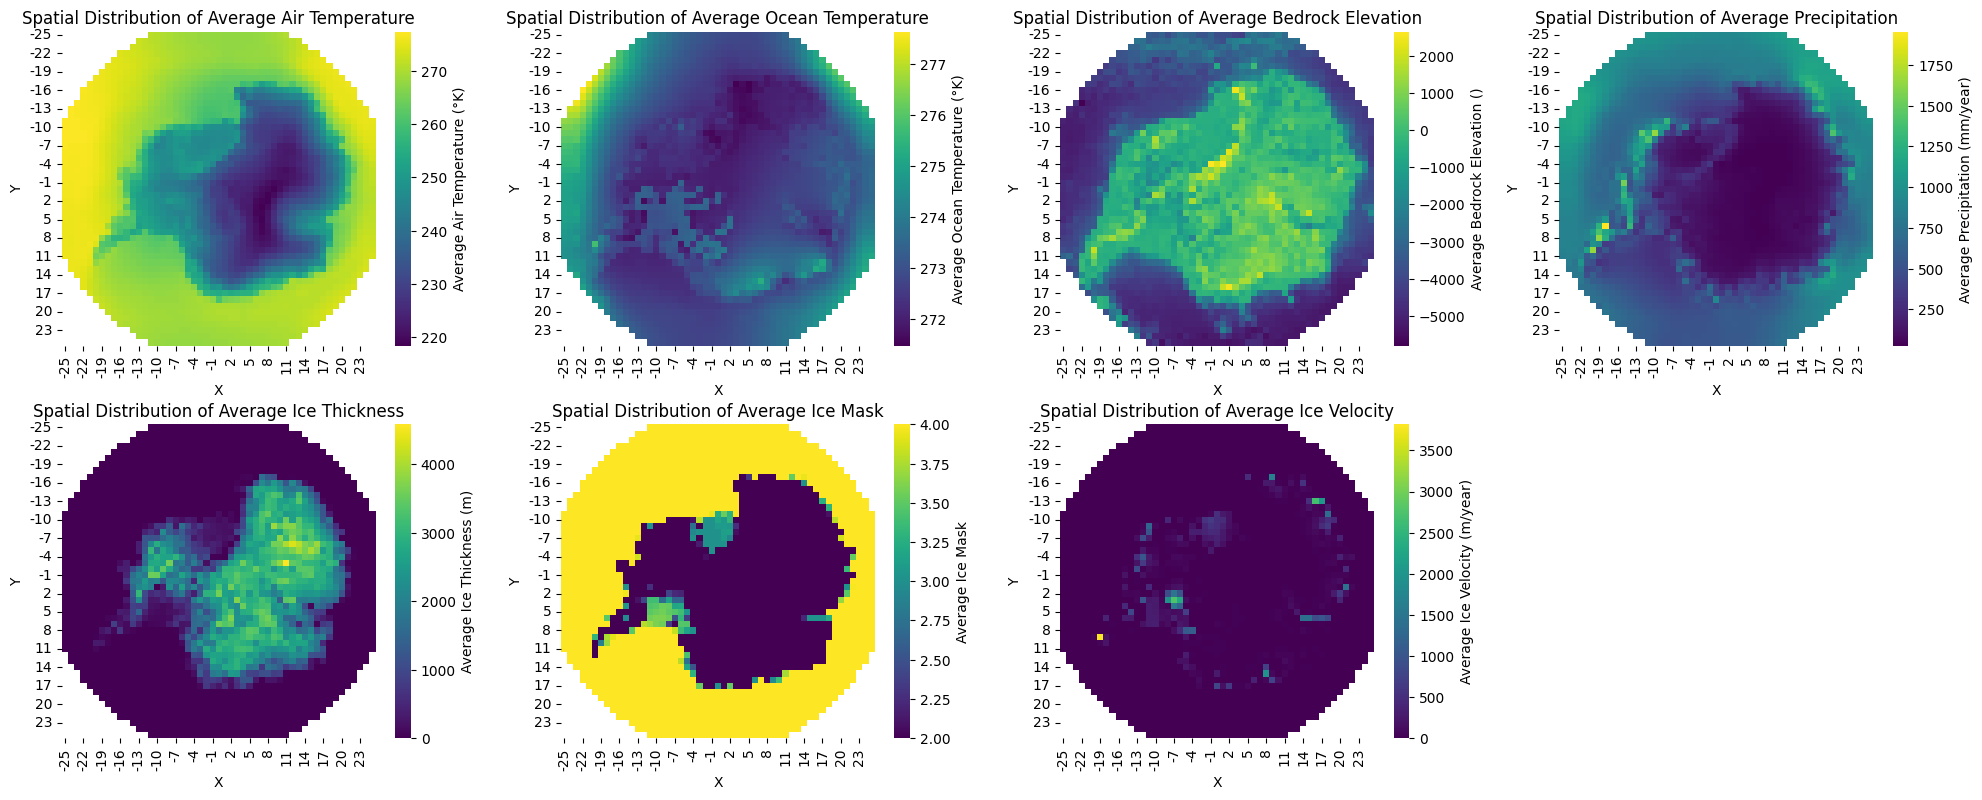

In [7]:
plot_group_spatial_heatmap(df, variables, 2, 4)

### 2.6 Dynamic Spatial Representations


### 2.7 Temporal Representations


In [ ]:
plot_group_line_chart(df, variables, 2, 3)

## 3. Correlation Analysis


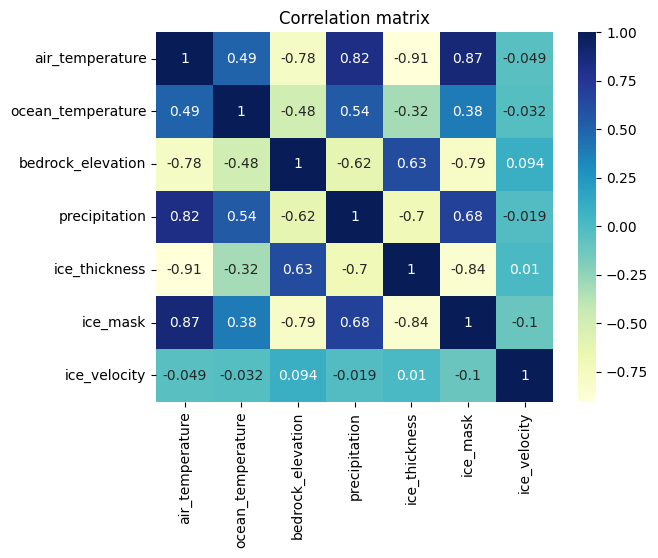

In [4]:
# Plot a correlation matrix
corr = df[variables].corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Correlation matrix")
plt.show()

## 4. Feature Engineering


### 3.2 Feature Creation


In [9]:
created_features = []

# Bedrock below Sea Level
df["bedrock_below_sea_level"] = df["bedrock_elevation"] < 0
created_features.append("bedrock_below_sea_level")

# Distance to Pole
df["dtp"] = np.sqrt((df["x"] - 4) ** 2 + df["y"] ** 2)
created_features.append("dtp")

# Rolling Standard Deviation
for feature in ["precipitation", "air_temperature"]:
    df[f"{feature}_rolling_std"] = df[feature].rolling(window=3).std()
    created_features.extend([f"{feature}_rolling_std"])

# Log Transformation of air_temperature
df["log_air_temperature"] = np.log(df["air_temperature"] + 1)
created_features.append("log_air_temperature")

# Coastline Encoding
df["coastline"] = 0
for index, row in df.iterrows():
    if row["ice_mask"] == 2:
        x = row["x"]
        y = row["y"]
        if (
            ((df["x"] == x) & (df["y"] == y + 1) & (df["ice_mask"] == 4)).any()
            or ((df["x"] == x) & (df["y"] == y - 1) & (df["ice_mask"] == 4)).any()
            or ((df["x"] == x + 1) & (df["y"] == y) & (df["ice_mask"] == 4)).any()
            or ((df["x"] == x - 1) & (df["y"] == y) & (df["ice_mask"] == 4)).any()
        ):
            df.at[index, "coastline"] = 1
created_features.append("coastline")

### 3.3 Created Feature Analysis


    bedrock_below_sea_level   dtp  precipitation_rolling_std  \
14                     True  15.0                        NaN   
15                     True  14.0                        NaN   
16                     True  13.0                   0.014593   
17                     True  12.0                   0.009095   
18                     True  11.0                   0.033908   

    air_temperature_rolling_std  log_air_temperature  
14                          NaN             0.578261  
15                          NaN             0.576742  
16                     0.002178             0.575841  
17                     0.001151             0.575488  
18                     0.000348             0.575517  


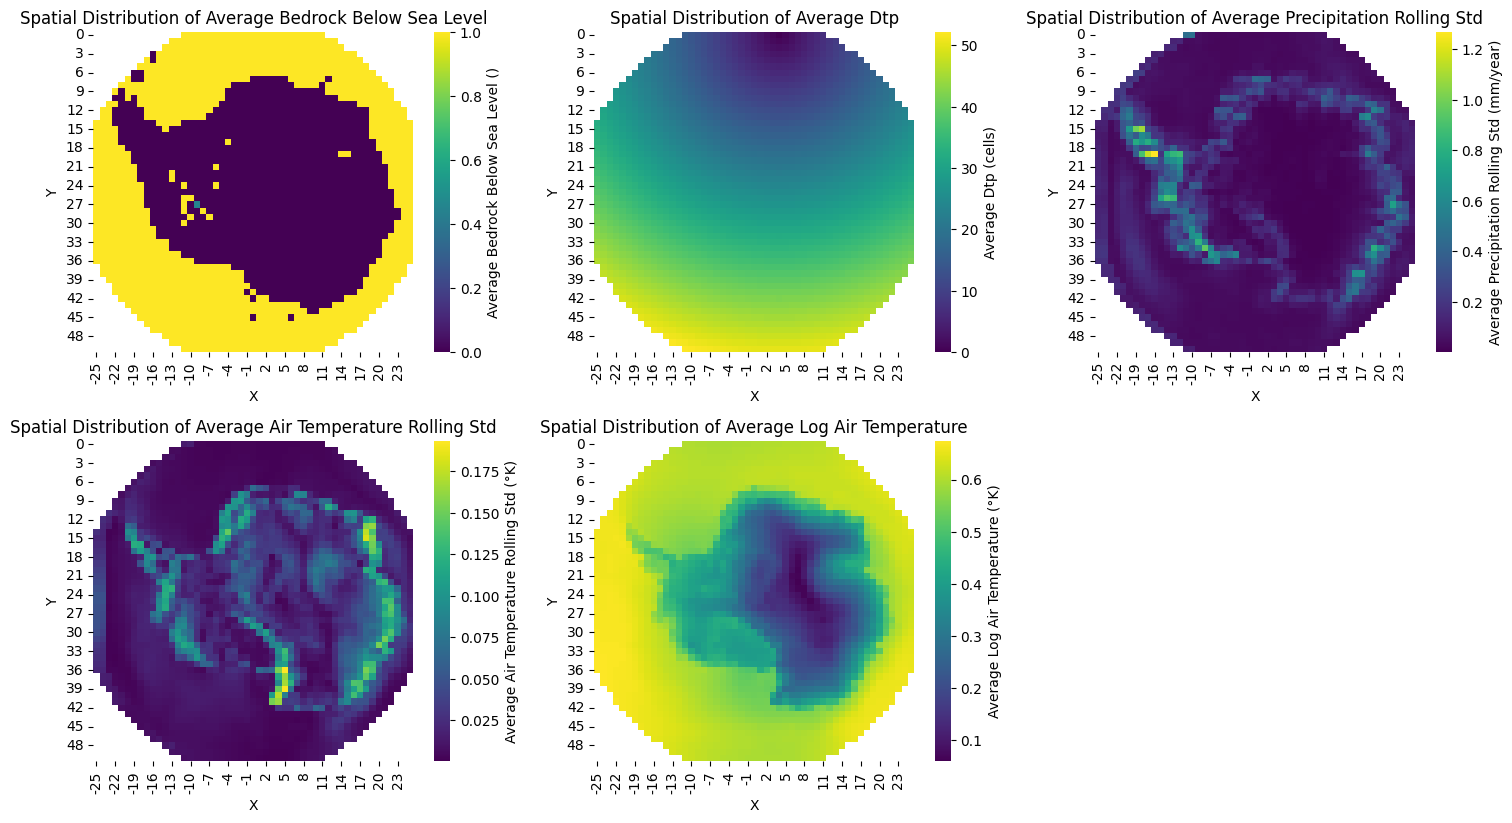

In [10]:
df_created = df[created_features]
print(df_created.head())
plot_group_spatial_heatmap(df, created_features, 4, 3)

### 3.4 Created Feature Correlation Analysis


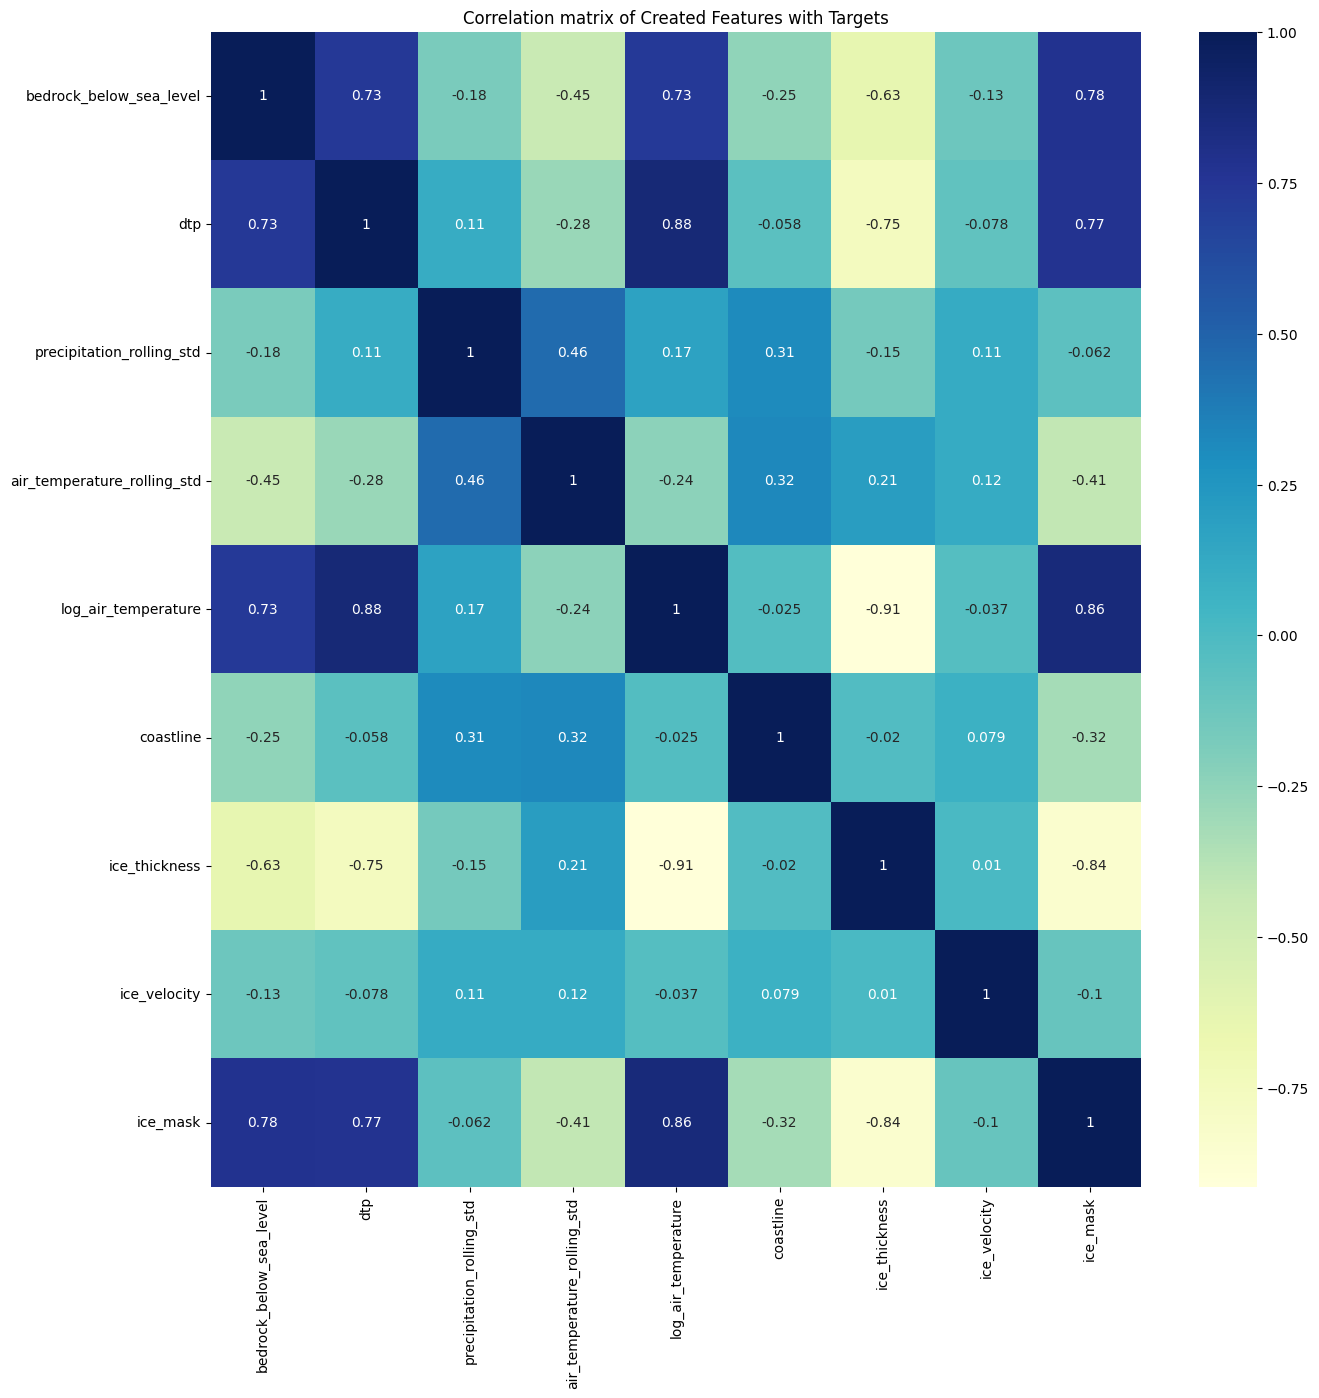

In [11]:
created_with_targets = created_features + targets.columns.tolist()
corr = df[created_with_targets].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Correlation matrix of Created Features with Targets")
plt.show()